<h1>Data Story Telling</h1>

<p>As background for this portion of my capstone project, we are looking to create a better estimator of points scored for each player rather than using the YTD average. As such, let's begin our analysis on the points and see if there are any trends or interesting correlations.</p>

In [2]:
#Importing necessary libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

<h3>Getting the data</h3>

<p>As mentioned in the data wrangling portion, we got our data from the NBA_PY library. Of course we need to clean our data for analysis and remove any unnecessary for this analysis. Also mentioned in the data wrangling section, we will be removing players who has less than 15 minutes of playing time and does not play more than 30 games.

The two functions below, pace_calculator and points_data, are used to help us get the data in a Pandas dataframe with the minimal amount of columns needed for this analysis.

Given my intuition in NBA games, we would expect there to be a correlation between the pace of the game and the number of points a player scores. The logic behind this is that a higher pace game will result in more scoring chances. More scoring chances will result in more points. Thus we would expect there to be a positive correlation between points scored and the pace of the game.
</p>

In [3]:
def pace_calculator(FGA, FTA, OREB, OPPDREB, FG, TOV, MIN):
    return 240 * (FGA + 0.4 * FTA - 1.07 * (FGA-FG)* (OREB/(OREB + OPPDREB)) + TOV) / MIN

In [19]:
def points_data(year):
    
    player = '../raw_data/player_stats_'+year+'.csv'
    team = '../raw_data/team_stats_'+year+'.csv'
    player_over='../raw_data/player_overall_15minsplus'+year+'.csv'
    player_position = '../raw_data/player_positions'+year+'.csv'
    starter='../raw_data/starter_bench'+year+'.csv'
    data = pd.read_csv(player)
    team_data = pd.read_csv(team)
    player_overall = pd.read_csv(player_over)
    player_pos = pd.read_csv(player_position)
    starter_bench = pd.read_csv(starter)

    team_data['VS_TEAM_ABBREVIATION'] = team_data['MATCHUP'].str[-3:]
    new_team = team_data[['TEAM_ID','TEAM_ABBREVIATION','VS_TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'FGM', 'FTA', 'FGA','OREB','DREB', 'TOV','MIN']]
    cols = ['TEAM_ABBREVIATION','GAME_ID','DREB']
    temp_col = team_data[cols]
    temp_col.columns = ['TEAM_ABBREVIATION','GAME_ID','OPPDREB']
    
    cleaned_team = pd.merge(new_team, temp_col, how='inner', left_on=['GAME_ID','VS_TEAM_ABBREVIATION'], right_on=['GAME_ID','TEAM_ABBREVIATION'], copy=False).drop('TEAM_ABBREVIATION_y', axis=1).rename(columns = {'TEAM_ABBREVIATION_x': 'TEAM_ABBREVIATION'})
    cleaned_team['PACE'] = pace_calculator(FGA = cleaned_team['FGA'], FTA = cleaned_team['FTA'], OREB = cleaned_team['OREB'], OPPDREB=cleaned_team['OPPDREB'], FG = cleaned_team['FGM'], TOV = cleaned_team['TOV'], MIN = cleaned_team['MIN'])
    pace = cleaned_team[['TEAM_ABBREVIATION', 'GAME_ID', 'PACE']]
    cleaned_team2 = pd.merge(cleaned_team, pace, how='inner', left_on=['GAME_ID','VS_TEAM_ABBREVIATION'], right_on=['GAME_ID','TEAM_ABBREVIATION'], copy=False).drop('TEAM_ABBREVIATION_y', axis=1).rename(columns = {'TEAM_ABBREVIATION_x': 'TEAM_ABBREVIATION', 'PACE_x': 'TEAM_PACE', 'PACE_y': 'VS_TEAM_PACE'})
    team_schedule = cleaned_team2[['TEAM_ID','TEAM_ABBREVIATION', 'VS_TEAM_ABBREVIATION','GAME_ID', 'TEAM_PACE', 'VS_TEAM_PACE']].sort_values(['TEAM_ABBREVIATION','GAME_ID'])
    team_schedule['GAME_NUMBER'] = np.array(list(range(82))*30)
    
    player_overall = player_overall[player_overall['GP'] > 30][['PLAYER_ID', 'PLAYER_NAME', 'PTS']]
    players = player_overall['PLAYER_ID'].tolist()
    data = data[data['PLAYER_ID'].isin(players)]
    data_with_number = pd.merge(data, team_schedule, how='left', left_on=['TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'])
    data_with_number = data_with_number.sort_values(['PLAYER_ID', 'GAME_NUMBER'])    
    data_with_number['YEAR'] = year 
    data_with_number = data_with_number.drop(columns=['Unnamed: 0', 'SEASON_ID','VIDEO_AVAILABLE', 'TEAM_ABBREVIATION_y' ])
    
    data_position = pd.merge(data_with_number,player_pos, how='left', left_on='PLAYER_ID', right_on='PLAYER_ID')
    data_starter_bench = pd.merge(data_position,starter_bench, how='left', left_on='PLAYER_ID', right_on='PLAYER_ID')
    data_starter_bench['SEASON'] = year
    data_starter_bench['FG2M'] = data_starter_bench['FGM'] -  data_starter_bench['FG3M']
    data_starter_bench['FG2A'] = data_starter_bench['FGA'] -  data_starter_bench['FG3A']
    data_starter_bench= data_starter_bench.drop(['Unnamed: 0_y','PLAYER_NAME_y', 'Unnamed: 0_x', 'FG3_PCT', 'FG_PCT'], axis=1)
    data_starter_bench = data_starter_bench.rename(columns={'TEAM_ABBREVIATION_x': 'TEAM_ABBREVIATION', 'PLAYER_NAME_x': 'PLAYER_NAME'})
    return data_starter_bench

In [20]:
points_2014 = points_data('2014-15')
points_2015 = points_data('2015-16')
points_2016 = points_data('2016-17')

combined = pd.concat([points_2014, points_2015, points_2016])

In [21]:
seasons = ['2014-15','2015-16','2016-17','2017-18']
for year in seasons:
    df = points_data(year)
    df.to_csv(path_or_buf="../Raw_Data/eda_data"+year+".csv")

<h3>Points Analysis</h3>

<p> Now that we have the data in a clean dataframe, let's start analyzing! We can see from the above that the mean is approximately 11 points per game and standard deviation is roughly 7.87 points. That is quite a huge variance!

Let's plot out the histogram and see what it looks like.</p>

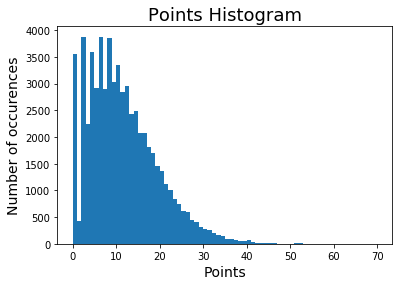

In [6]:
_ = plt.hist(combined['PTS'], bins=70)
_ = plt.xlabel('Points', fontsize=14)
_ = plt.ylabel('Number of occurences', fontsize=14)
_ = plt.title('Points Histogram', fontsize=18)

<p> We can see here that a majority of players are relatively low scoring and tends to tail off towards the end. This is looking like a Chi-Square distribution on first glance. Of course we will need to do some more rigorous testing on this to ensure that it is indeed Chi-Square. However, this is an interesting plot on the first go around.

Now, as there are 82 games in the season, let's see if there is any trend that we can see in the points scored over the season.</p>

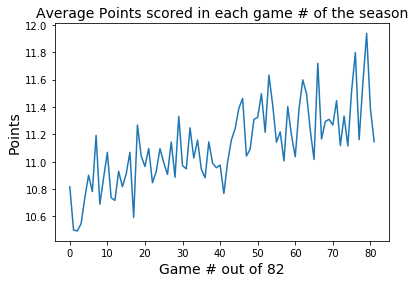

In [7]:
_ = plt.plot(combined[['GAME_NUMBER', 'PTS']].groupby(['GAME_NUMBER']).mean())
_ = plt.xlabel('Game # out of 82', fontsize=14)
_ = plt.ylabel('Points', fontsize=14)
_ = plt.title('Average Points scored in each game # of the season', fontsize=14)

<p>We can see that there is an increasing trend as the seasn progresses, the number of points scored increases. We would expect this because in the beginning of the season, players are a little bit rusty and there may be new team members. As the season progresses, players get more comfortable and start to understand their team chemistry better. This indicates that in our machine learning algorithmn, we'll need to account for the # of game played out of the season.</p>

<h3>Checking Correlations</h3>

<p>Let's create a correlation matrix to see what variables will require further analysis.</p>

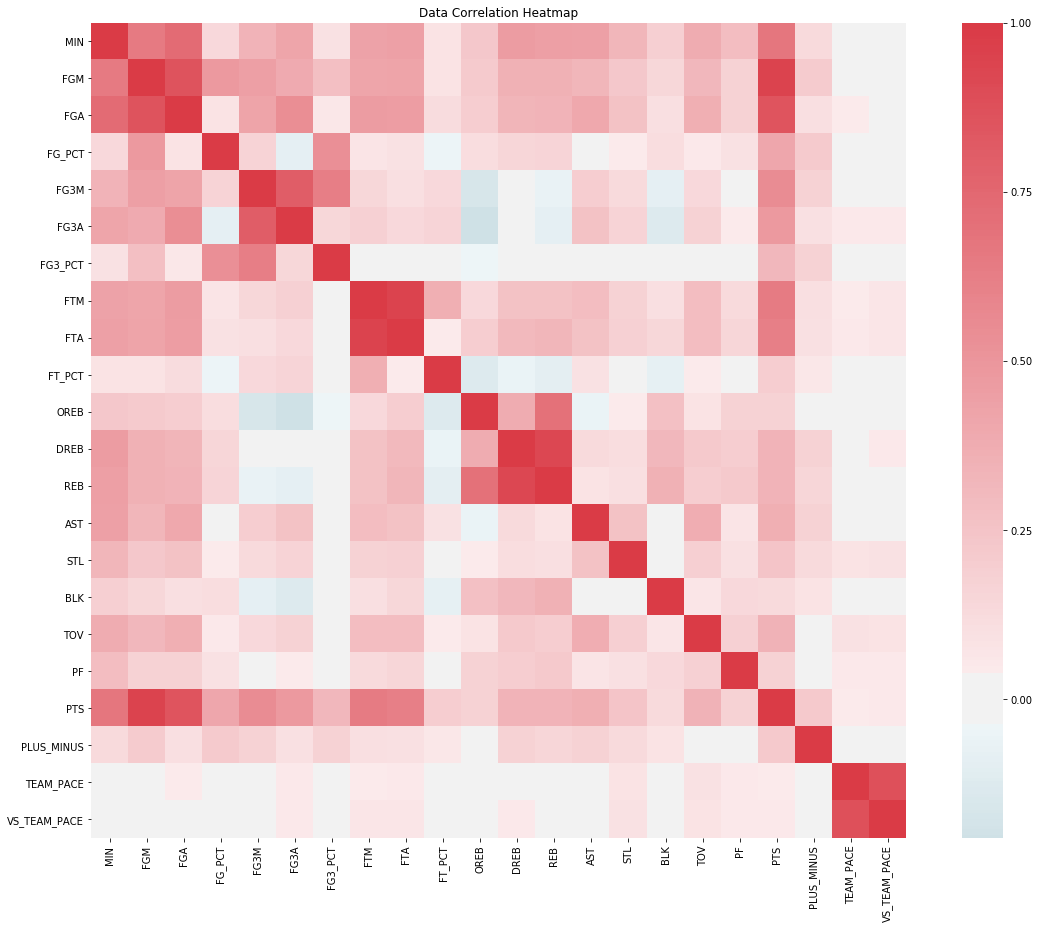

In [8]:
# Create Dictionary for Heatmap Font Sizes
heatmap = {'xtick.labelsize':20, 'ytick.labelsize':20,'axes.titlesize':25, 'axes.labelsize':25}

# Create Correlation Matrix to See Noteable Correlaitons
f, ax = plt.subplots(figsize=(20, 15))
corr = combined[['MIN', 'FGM', 'FGA', 'FG_PCT','FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB','REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS','TEAM_PACE', 'VS_TEAM_PACE']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            center = 0, square=True, ax=ax)
plt.title('Data Correlation Heatmap')
_ = plt.rcParams.update(heatmap)
plt.show()

In [9]:
corr['PTS'][corr['PTS'] > 0.3]

MIN        0.676367
FGM        0.952399
FGA        0.857546
FG_PCT     0.410040
FG3M       0.547979
FG3A       0.478919
FG3_PCT    0.313919
FTM        0.642284
FTA        0.620487
DREB       0.344303
REB        0.338046
AST        0.362485
TOV        0.349379
PTS        1.000000
Name: PTS, dtype: float64

<p> From the initial analysis here, we would expect the first few categories to be directly correlated to the number of points scored. The reason being is that the amount of field goals made, three pointers made and free throws made have a direct impact to the number of points.

What is interesting is that defensive rebounds, rebounds, assists and turnovers all also have a significant impact on points. We'll need to explore this in detail once we can cut the data in higher detail (the players positions). My gut reaction is that higher rebounds will correlate directly with big men (centers).</p>

In [10]:
guards = combined[combined.GUARD.notnull()].assign(Position='Guard')
guards = guards[guards['PTS'] < 45]
centers = combined[combined.CENTER.notnull()].assign(Position='Center')
centers = centers[centers['PTS'] < 45]
forwards = combined[combined.FORWARD.notnull()].assign(Position='Forward')
forwards = forwards[forwards['PTS'] < 45]
cdf = pd.concat([guards, centers, forwards]) 
mdf = pd.melt(cdf, id_vars=['Position'], value_vars=['PTS'], var_name=['PTS'])
mdf.head()

,Position,PTS,value
0,Guard,PTS,19
1,Guard,PTS,31
2,Guard,PTS,21
3,Guard,PTS,28
4,Guard,PTS,39


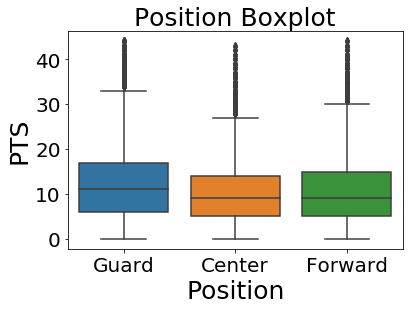

In [12]:
ax = sns.boxplot(x="Position", y="value", data=mdf)   
ax = plt.title('Position Boxplot')
ax = plt.ylabel('PTS')
plt.show()

In [15]:
starters = combined[combined['STARTER'] == 'YES'].assign(STARTER='Is a starter')
starters  = starters [starters ['PTS'] < 45]
in_between = combined[combined['STARTER'] == 'IN_BETWEEN'].assign(STARTER='Sometimes A Starter')
in_between = in_between[in_between['PTS'] < 45]
bench = combined[combined['STARTER'] == 'NO'].assign(STARTER='Is a BENCH')
bench = bench[bench['PTS'] < 45]
cdf = pd.concat([starters, in_between, bench]) 
mdf = pd.melt(cdf, id_vars=['STARTER'], value_vars=['PTS'], var_name=['PTS'])
mdf.head()

,STARTER,PTS,value
0,Is a starter,PTS,10
1,Is a starter,PTS,18
2,Is a starter,PTS,6
3,Is a starter,PTS,2
4,Is a starter,PTS,4


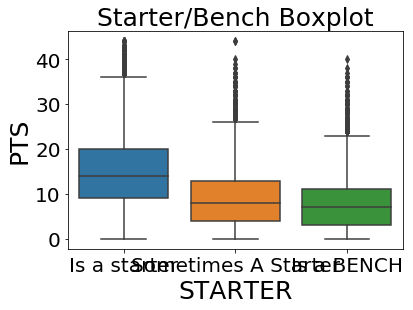

In [17]:
ax = sns.boxplot(x="STARTER", y="value", data=mdf)  
ax = plt.title('Starter/Bench Boxplot')
ax = plt.ylabel('PTS')
plt.show()

<h3>Conclusions</h3>

<p>
Here are the conclusions we have drawn from this data story telling portion of the capstone project. We'll need to validate in the next section to ensure that our findings are correct.
    • The histogram indicates that there may be a Chi-square distribution in the points scored.
    • There is a clear increasing trend in points scored over the course of the season.
    • Given rebounds, assists and turnovers all have a positive correlation on the points scored, we may need to investigate further to see if the rebounds is positively correlated only for centers/big men, and if assists are only positively correlated for guards. We will need to add this flag to our data.
</p>